<div style="border:solid SkyBlue 2px; padding: 40px">
Привет!👋
Меня зовут Илья.

Свои комментарии, по примеру прошлого проекта, я буду выделять  <font color='SkyBlue'>Голубым цветом</font>.

          
<div class="alert alert-info">
Вот он мой комментарий)
</div>    

Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

## Проект "Прогнозирование количества заказов такси"

<b>Описание проекта</b>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Содержание

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Настройки и импорты

In [2]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as pl
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

#pip install catboost
#pip install lightgbm

import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

## Подготовка

In [3]:
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
data.describe(include='all')

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data.isna().sum()

num_orders    0
dtype: int64

In [8]:
data.index.is_monotonic

True

Сделаем семплирование по часу, так как предсказываем количество заказов такси на следующий час

In [9]:
data = data.resample('1H').sum()

In [10]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [11]:
f"Временной промежуток данных: {data.index.min()} - {data.index.max()}"

'Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:00:00'

### Вывод: 
В данных нет пропусков, дупликатов
Был произведен ресемплинг 1 час

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

## Анализ

Построим графики количества заказов по часам, дням, и месяцам.

Создадим признаки для горизонта прогнозирования в один шаг

In [12]:
def get_features(data_new):
    data_func = data_new.copy()
    data_func['month'] = data_func.index.month
    data_func['day'] = data_func.index.day
    data_func['dayofweek'] = data_func.index.dayofweek
    data_func['hour'] = data_func.index.hour
    
    for lag in range(1, 6):
        data_func['lag_{}'.format(lag)] = data_func['num_orders'].shift(lag)
    
    data_func['rolling_mean'] = data_func['num_orders'].shift().rolling(1).mean()
    data_func.dropna(inplace=True)
    
    return data_func

<div class="alert alert-block alert-info">

<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
1. Это хорошая практика (не изменять глобальные переменные внутри функции), которая улучшает читаемость кода.
2. В какой-то момент может появиться необходимость подбирать некоторые параметры используемый внутри функции. В этот момент копирование датасета станет обязательным.
</div>

In [17]:
data_new = get_features(data)

In [18]:
data_new

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,43.0
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,6.0
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,12.0
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,15.0
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,207.0
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,136.0
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,154.0


In [19]:
data.shape

(4416, 1)

In [20]:
data_new.shape

(4411, 11)

In [21]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


[Text(0.5, 0, 'Временной промежуток по месяцам')]

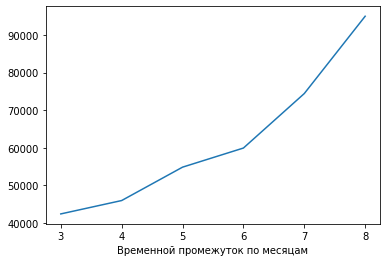

In [22]:
data_new.groupby('month')['num_orders'].sum().plot().set(xlabel='Временной промежуток по месяцам')

[Text(0.5, 0, 'Временной промежуток по дням месяца')]

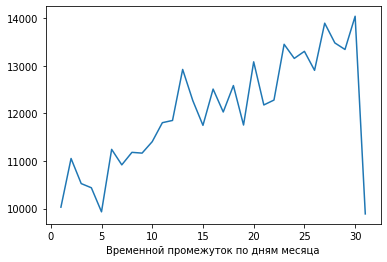

In [23]:
data_new.groupby('day')['num_orders'].sum().plot().set(xlabel='Временной промежуток по дням месяца')

[Text(0.5, 0, 'Временной промежуток по дню недели')]

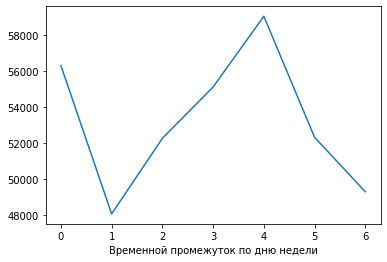

In [24]:
data_new.groupby('dayofweek')['num_orders'].sum().plot().set(xlabel='Временной промежуток по дню недели')


[Text(0.5, 0, 'Временной промежуток по часам')]

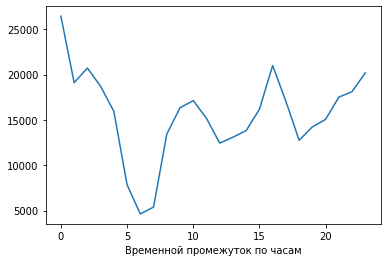

In [25]:
data_new.groupby('hour')['num_orders'].sum().plot().set(xlabel='Временной промежуток по часам')

По графикам видно,что в пятницу и вечером больше всего заказов.

Разложим данные на три составляющие: тренд, сезонность и остаток. 

In [26]:
decomposed = seasonal_decompose(data)

[Text(0.5, 0, 'Временной промежуток'), Text(0, 0.5, 'ср.р Кол-во заказов')]

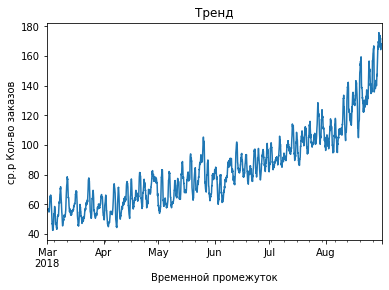

In [27]:
decomposed.trend.plot(
        title = 'Тренд',
 ).set(xlabel='Временной промежуток', ylabel='ср.р Кол-во заказов')

[Text(0.5, 0, 'Временной промежуток'), Text(0, 0.5, 'ср.р Кол-во заказов')]

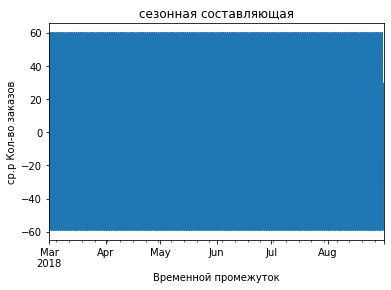

In [28]:
decomposed.seasonal.plot(
        title = 'сезонная составляющая',
 ).set(xlabel='Временной промежуток', ylabel='ср.р Кол-во заказов')

[Text(0.5, 0, 'Временной промежуток за сутки'),
 Text(0, 0.5, 'ср.р Кол-во заказов')]

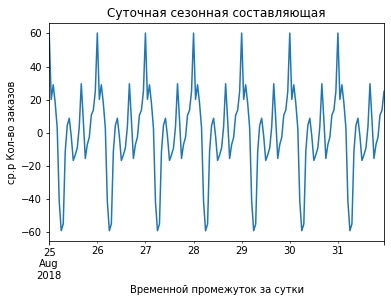

In [29]:
decomposed.seasonal.tail(24*7).plot(
        title = 'Суточная сезонная составляющая',
 ).set(xlabel='Временной промежуток за сутки', ylabel='ср.р Кол-во заказов')

[Text(0.5, 0, 'Временной промежуток'), Text(0, 0.5, 'ср.р Кол-во заказов')]

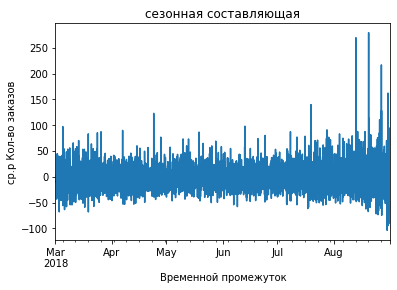

In [30]:
decomposed.resid.plot(
        title = 'сезонная составляющая',
 ).set(xlabel='Временной промежуток', ylabel='ср.р Кол-во заказов')

In [31]:
#from matplotlib import pyplot
#from statsmodels.tsa.seasonal import seasonal_decompose
#result = seasonal_decompose(data)
#result.plot()
#pyplot.show()

## Вывод:
Наблюдается равномерный рост заказов со временем<br>
Присутствует законномерности кол-во заказав в течении дня - спад ночью, рост с утра и днем, пик к вечеру<br>
Пятница на недели самый загружженый день<br>

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале!
</div>

## Обучение

Разделим данные на обучающую и тестовую выборки

In [32]:
features = data_new.drop(['num_orders'], axis=1) 
target = data_new['num_orders']

Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.

In [33]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target,  test_size=0.5, shuffle=False,random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.2, shuffle=False, random_state=12345) 

In [34]:
features_train = features_train.dropna()
features_test = features_test.dropna()
features_valid = features_valid.dropna()
target_train = target_train.dropna()
target_test = target_test.dropna()
target_valid = target_valid.dropna()

In [35]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(2205, 10)
(1764, 10)
(442, 10)
(2205,)
(1764,)
(442,)


In [74]:
data.shape

(4416, 1)

In [76]:
442/4416

0.10009057971014493

Линейная регрессия

In [77]:
model_lr = LinearRegression()
 
model_lr.fit(features_train, target_train)
 
train_pred_lr = model_lr.predict(features_train)
test_pred_lr = model_lr.predict(features_valid)

RMSE_train_lr  = mean_squared_error(target_train, train_pred_lr, squared=False)
RMSE_test_lr = mean_squared_error(target_valid, test_pred_lr, squared=False)

print("RMSE обучающей выборки:", RMSE_train_lr)
print("RMSE валидациооной выборки: ", RMSE_test_lr)

RMSE обучающей выборки: 27.118902777811353
RMSE валидациооной выборки:  35.014538349859045


Древо решений

In [78]:
param = {"max_depth": list(range(4,30,2)),
                 "min_samples_leaf": list(range(10, 80,10)),
                 "max_leaf_nodes": list(range(10, 80,10)), }

In [80]:
DTS = DecisionTreeRegressor() 
model_dts = RandomizedSearchCV(estimator=DTS,
                                      param_distributions= param,  scoring='neg_mean_squared_error', random_state=12345, n_jobs=-1, cv=TimeSeriesSplit())

model_dts.fit(features_train, target_train)

train_pred_dts = model_dts.predict(features_train)
test_pred_dts = model_dts.predict(features_valid)

RMSE_train_dts  = mean_squared_error(target_train, train_pred_dts, squared=False)
RMSE_test_dts  = mean_squared_error(target_valid, test_pred_dts, squared=False)

print('Лучшие параметры:', model_dts.best_params_)
print("RMSE обучающей выборки:", RMSE_train_dts)
print("RMSE валидациооной выборки: ", RMSE_test_dts)

Лучшие параметры: {'min_samples_leaf': 10, 'max_leaf_nodes': 70, 'max_depth': 20}
RMSE обучающей выборки: 17.964418333741502
RMSE валидациооной выборки:  37.54961989349251


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично!
</div>

In [81]:
%time
model_cat = CatBoostRegressor()

model_cat.fit(features_train, target_train)

train_pred_dts = model_cat.predict(features_train)
test_pred_dts = model_cat.predict(features_valid)

RMSE_train_cat  = mean_squared_error(target_train, train_pred_dts, squared=False)
RMSE_test_cat  = mean_squared_error(target_valid, test_pred_dts, squared=False)

print("RMSE обучающей выборки:", RMSE_train_cat)
print("RMSE валидациооной выборки: ", RMSE_test_cat)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Learning rate set to 0.046391
0:	learn: 32.2732975	total: 49.1ms	remaining: 49s
1:	learn: 31.7105150	total: 51.2ms	remaining: 25.5s
2:	learn: 31.0860543	total: 53.3ms	remaining: 17.7s
3:	learn: 30.6736809	total: 55.3ms	remaining: 13.8s
4:	learn: 30.1968153	total: 57.3ms	remaining: 11.4s
5:	learn: 29.6701213	total: 59.3ms	remaining: 9.82s
6:	learn: 29.1859851	total: 60.7ms	remaining: 8.61s
7:	learn: 28.7177179	total: 62ms	remaining: 7.68s
8:	learn: 28.3668534	total: 64.3ms	remaining: 7.08s
9:	learn: 27.9698975	total: 66.4ms	remaining: 6.58s
10:	learn: 27.6363322	total: 68.6ms	remaining: 6.17s
11:	learn: 27.3065786	total: 71ms	remaining: 5.84s
12:	learn: 26.9849082	total: 72.9ms	remaining: 5.53s
13:	learn: 26.6695787	total: 74.4ms	remaining: 5.24s
14:	learn: 26.3465975	total: 75.9ms	remaining: 4.98s
15:	learn: 26.0589938	total: 77.4ms	remaining: 4.76s
16:	learn: 25.8628752	total: 79ms	remaining: 4.57s
17:	learn: 25.6491860	t

In [82]:
%time

model_LGBM = lgb.LGBMRegressor()

model_LGBM.fit(features_train, target_train)

train_pred_LGBM = model_LGBM.predict(features_train)
test_pred_LGBM = model_LGBM.predict(features_valid)

RMSE_train_LGBM  = mean_squared_error(target_train, train_pred_LGBM, squared=False)
RMSE_test_LGBM  = mean_squared_error(target_valid, test_pred_LGBM, squared=False)

print("RMSE обучающей выборки:", RMSE_train_LGBM)
print("RMSE валидациооной выборки: ", RMSE_test_LGBM)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
RMSE обучающей выборки: 10.909698478696187
RMSE валидациооной выборки:  32.33334295413358


In [83]:
index = ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor', 'LGBMRegressor']

result_data = [
    {'RMSE обучающей выборки:.' : RMSE_train_lr, 'RMSE валидациооной выборки': RMSE_test_lr},
    {'RMSE обучающей выборки:.' : RMSE_train_dts, 'RMSE валидациооной выборки': RMSE_test_dts},
    {'RMSE обучающей выборки:.' : RMSE_train_cat, 'RMSE валидациооной выборки': RMSE_test_cat},
    {'RMSE обучающей выборки:.' : RMSE_train_LGBM, 'RMSE валидациооной выборки': RMSE_test_LGBM},
]

result_table = pd.DataFrame(result_data, index=index)
result_table

,RMSE обучающей выборки:.,RMSE валидациооной выборки
LinearRegression,27.118903,35.014538
DecisionTreeRegressor,17.964418,37.549620
CatBoostRegressor,9.901570,32.721167
LGBMRegressor,10.909698,32.333343


Вывод: Лучшие результаты показывают модели CatBoostRegressor и LGBMRegressor.
Модель LGBMRegressor показывает свои предсказания быстрее, поэтому возьмем для тестирования в дальнейшем ее.
    

## Тестирование

In [84]:
gbm = lgb.LGBMRegressor()
gbm.fit(features_train, target_train)
pred2 = gbm.predict(features_test)
rmse =  mean_squared_error(target_test, pred2, squared=False)
print('RMSE обычной модели:' ,  '%.4f' % rmse)

RMSE обычной модели: 60.4339


In [54]:
features_train, features_test, target_train, target_test2 = train_test_split(features, target,  test_size=0.1, shuffle=False,random_state=12345)

In [55]:
gbm = lgb.LGBMRegressor()
gbm.fit(features_train, target_train)
pred2 = gbm.predict(features_test)
rmse =  mean_squared_error(target_test, pred2, squared=False)
print('RMSE обычной модели:' ,  '%.4f' % rmse)

RMSE обычной модели: 44.6955


<div class="alert alert-block alert-success">

<b>Успех:</b> Так тоже можно. Объединять выборки можно было через `pd.concat()`.
</div>

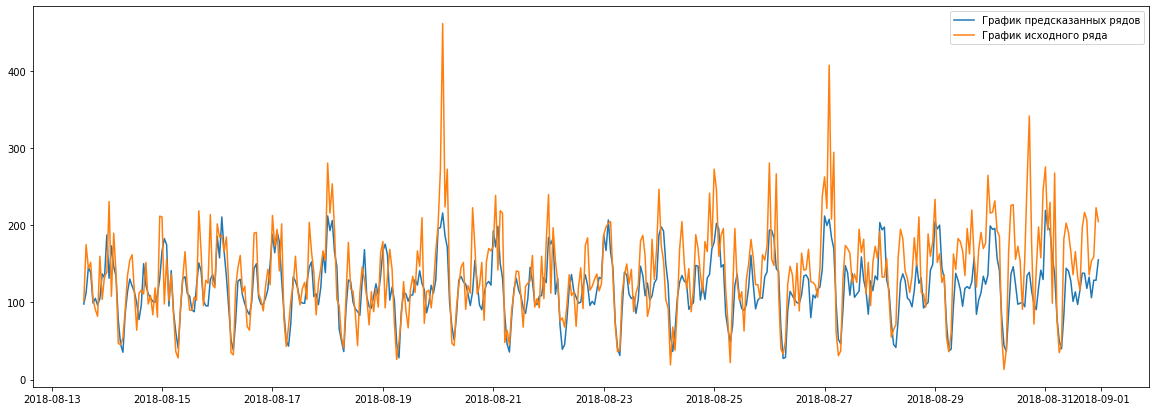

In [67]:
fig, ax = pl.subplots(figsize=(20, 7))
ax.plot(pd.Series(pred2, index = target_test.index), label='График предсказанных рядов')
ax.plot(target_test, label='График исходного ряда')
legend = ax.legend(loc='upper right', fontsize= 10)

Добились нужного результата.


<div class="alert alert-block alert-info">
<b>Совет: </b> Финальные предсказания можно было визуализирвоать: графики исходного и предсказанных рядов.
</div>

Итоговый вывод:
В данном проекте были изученный данные,
расмотренны 4 модели провденно их сравнение и выбрана лучшая модель
Было достигнуто значение метрики RMSE на тестовой выборке не больше 48.